In [ ]:
# imports
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import random

In [3]:
# load world3 data as json
json_file = open("world3-03_variables.json")
w3_vars = json.loads(json_file.read())
json_file.close()

In [4]:
# convert world3 to a network
G = nx.DiGraph()
for name, val in w3_vars.items():
    G.add_node(name, var_type=val["type"])
    if val["dependencies"] is not None:
        G.add_edges_from([(dep, name) for dep in val["dependencies"]])

G: DiGraph with 316 nodes and 507 edges


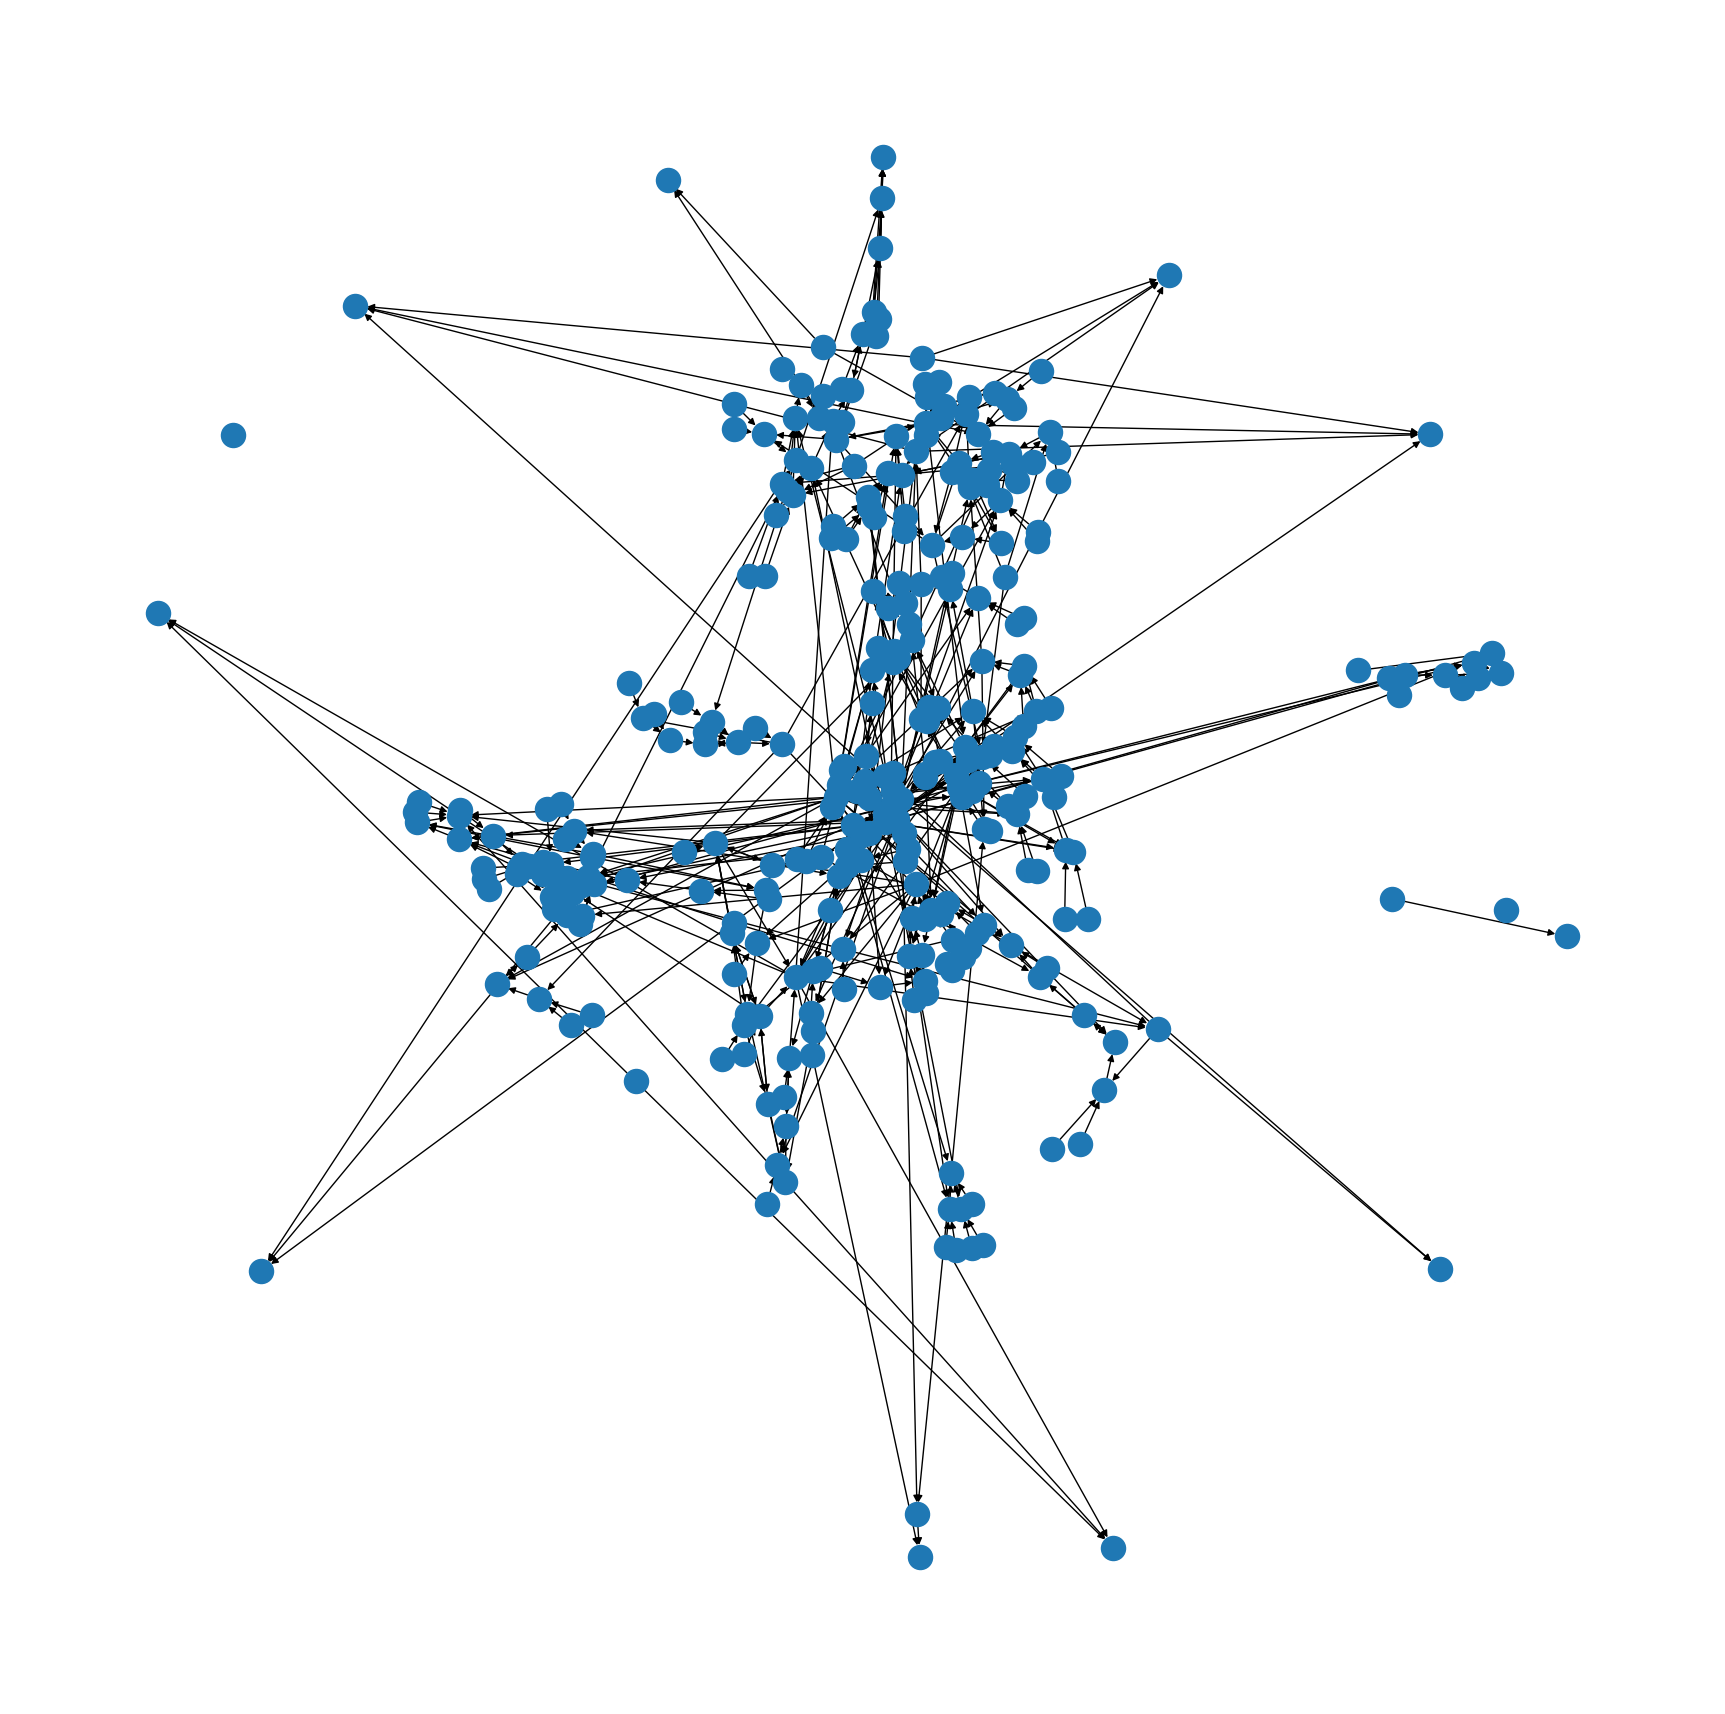

In [5]:
# display the loaded graph
print(f"G: {G}")
f, ax = plt.subplots(figsize=(22, 22))
nx.draw(G)

# Cycle Analysis

In [ ]:
# NOTE: we might consider cycle basis, not sure it would be relevant

# Compute all cycles in world3 up to length length_bound
length_bound = 75
directed_cycles = nx.simple_cycles(G, length_bound=length_bound)
directed_cycles = list(directed_cycles)

for length 75, found 1863803 cycles
found mean=43.63671428793708, std=8.209200350268098


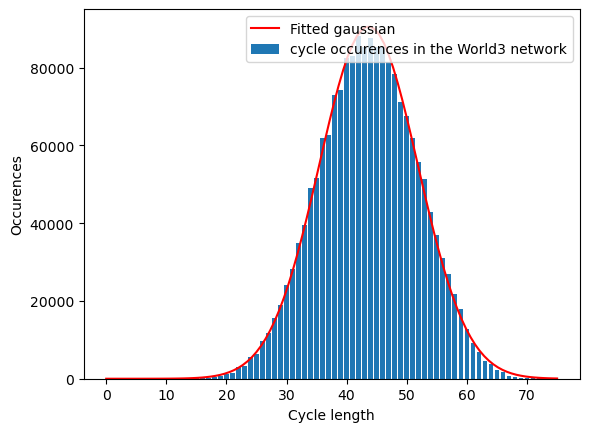

['urban_and_industrial_land', 'land_removal_for_urban_and_industrial_use']
['deaths_45_to_64', 'population_45_to_64']
['land_fertility', 'land_fertility_degredation']
['land_fertility', 'land_fertility_regeneration']
['deaths_65_plus', 'population_65_plus']
['industrial_capital', 'industrial_capital_depreciation']
['population_0_to_14', 'deaths_0_to_14']
['population_0_to_14', 'maturation_14_to_15']
['land_erosion_rate', 'arable_land']
['deaths_15_to_44', 'population_15_to_44']
['population_15_to_44', 'maturation_44_to_45']
['population_45_to_64', 'maturation_64_to_65']
['persistent_pollution', 'persistent_pollution_assimilation_rate']
['land_yield_technology_change_rate', 'land_yield_technology']
['persistent_pollution_technology', 'persistent_pollution_technology_change_rate']
['service_capital', 'service_capital_depreciation']
['resource_technology_change_rate', 'resource_conservation_technology']
['industrial_capital_investment', 'industrial_capital', 'industrial_output']
['potenti

In [ ]:
total_count = len(directed_cycles)
print(f"for length {length_bound}, found {total_count} cycles")

length_occurrences = {}
for cycle in directed_cycles:
    length = len(cycle)
    if length_occurrences.get(length) is None:
        length_occurrences[length] = 0
    length_occurrences[length] += 1
plt.bar(length_occurrences.keys(), length_occurrences.values(), label="cycle occurences in the World3 network")

mean = 0
for length, occ in length_occurrences.items():
    mean += length * occ
mean = mean / total_count

std = 0
for length, occ in length_occurrences.items():
    std += ((length - mean) ** 2) * occ
std = (std / total_count) ** 0.5

print(f"found mean={mean}, std={std}")

x = np.linspace(0, length_bound, 100)
plt.plot(x, total_count * stats.norm.pdf(x, mean, std), label='Fitted gaussian', color='red')
plt.xlabel("Cycle length")
plt.ylabel("Occurences")
plt.legend()
plt.show()


sorted_cycles = sorted(directed_cycles, key= lambda x: len(x))

print_count = 20
for cycle in sorted_cycles[:print_count]:
    print(cycle)

In [47]:
# Perform the same analysis with a random graph
n, e = G.number_of_nodes(), G.number_of_edges()
e_r_G = nx.erdos_renyi_graph(n, e / (n * (n-1)), directed=True)
cc = nx.number_strongly_connected_components(e_r_G)
print(f"Created random erdos_renyi graph with {e_r_G.number_of_nodes()} nodes and {e_r_G.number_of_edges()} edges.")
print(f"It features {cc} strongly connected components")
print(f"By comparison, world3 features {nx.number_strongly_connected_components(G)} strongly connected components")

# Compute the directed cycles in the random graph
random_length_bound = 80
random_directed_cycles = nx.simple_cycles(e_r_G, length_bound=random_length_bound)
random_directed_cycles = list(random_directed_cycles)

Created random erdos_renyi graph with 316 nodes and 498 edges.
It features 189 strongly connected components
By comparison, world3 features 163 strongly connected components


for length 75, found 24748 cycles
found mean=44.97531113625343, std=9.79586767783598


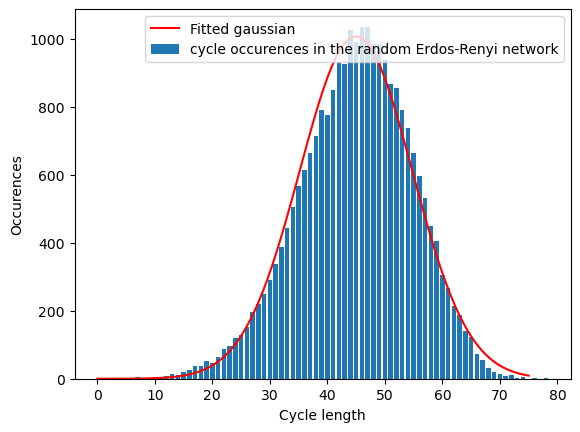

In [48]:
random_total_count = len(random_directed_cycles)
print(f"for length {length_bound}, found {random_total_count} cycles")

random_length_occurrences = {}
for cycle in random_directed_cycles:
    length = len(cycle)
    if random_length_occurrences.get(length) is None:
        random_length_occurrences[length] = 0
    random_length_occurrences[length] += 1
plt.bar(random_length_occurrences.keys(), random_length_occurrences.values(), label="cycle occurences in the random Erdos-Renyi network")

random_mean = 0
for length, occ in random_length_occurrences.items():
    random_mean += length * occ
random_mean = random_mean / random_total_count

random_std = 0
for length, occ in random_length_occurrences.items():
    random_std += ((length - random_mean) ** 2) * occ
random_std = (random_std / random_total_count) ** 0.5

print(f"found mean={random_mean}, std={random_std}")

x = np.linspace(0, length_bound, 100)
plt.plot(x, random_total_count * stats.norm.pdf(x, random_mean, random_std), label='Fitted gaussian', color='red')
plt.xlabel("Cycle length")
plt.ylabel("Occurences")
plt.legend()
plt.show()

# Analysis
Similar mean and npstd, but way more cycles overall. This is consistent across runs, however I would need to make several runs (at least 10) to perform statistics (mean of means/stds, and means of total counts).
We can clearly see that in all cases it very closely follows the gaussian distribution.
The conclusion would be that the world3 model tends to have many more cycles than expected at random.

In [51]:
# Code taken from my (Ismaïl's) Assignment 2 submission 
def rewiring(G, iterations=10000):
    # select 2 edges at random
    edges = list(G.edges())
    m = len(edges)

    for i in range(iterations):
        e1_idx = random.randint(0, m-1)
        e2_idx = e1_idx
        # ensure different sampled edges
        while e2_idx == e1_idx:
            e2_idx = random.randint(0, m-1) 
        e1 = edges[e1_idx] # e1 = (A,B)
        e2 = edges[e2_idx] # e2 = (C,D)
        A, B = e1
        C, D = e2
        new_e1 = (A, D)
        new_e2 = (C, B)
    
        # we create a multi-edge if (A,D) or (C,B) is already in E
        if G.has_edge(A, D) or G.has_edge(C, B):
            continue

        # we create a self-loop if A==D or C==B
        if A==D or C==B:
            continue

        # make the replacement
        edges[e1_idx] = new_e1
        edges[e2_idx] = new_e2

    return nx.from_edgelist(edges, create_using=nx.DiGraph)

In [58]:
rewired_G = rewiring(G)

# Compute the directed cycles in the rewired graph
rewired_length_bound = 80
rewired_directed_cycles = nx.simple_cycles(rewired_G, length_bound=rewired_length_bound)
rewired_directed_cycles = list(rewired_directed_cycles)

for length 75, found 18010 cycles
found mean=37.870405330372016, std=8.25808548663417


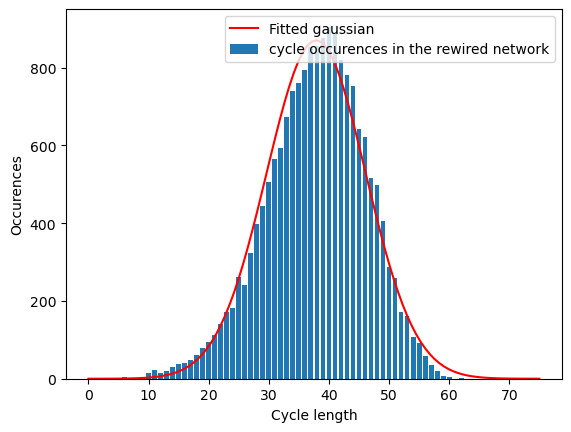

In [59]:
rewired_total_count = len(rewired_directed_cycles)
print(f"for length {length_bound}, found {rewired_total_count} cycles")

rewired_length_occurrences = {}
for cycle in rewired_directed_cycles:
    length = len(cycle)
    if rewired_length_occurrences.get(length) is None:
        rewired_length_occurrences[length] = 0
    rewired_length_occurrences[length] += 1
plt.bar(rewired_length_occurrences.keys(), rewired_length_occurrences.values(), label="cycle occurences in the rewired network")

rewired_mean = 0
for length, occ in rewired_length_occurrences.items():
    rewired_mean += length * occ
rewired_mean = rewired_mean / rewired_total_count

rewired_std = 0
for length, occ in rewired_length_occurrences.items():
    rewired_std += ((length - rewired_mean) ** 2) * occ
rewired_std = (rewired_std / rewired_total_count) ** 0.5

print(f"found mean={rewired_mean}, std={rewired_std}")

x = np.linspace(0, length_bound, 100)
plt.plot(x, rewired_total_count * stats.norm.pdf(x, rewired_mean, rewired_std), label='Fitted gaussian', color='red')
plt.xlabel("Cycle length")
plt.ylabel("Occurences")
plt.legend()
plt.show()

# Analysis
Same, we need to perform statistics, but the conclusion go in the same way: world3 is specifically heavily cycled, with cycles of roughly expected length distribution.